In [5]:
import os
import pandas as pd
import geopandas as gpd
import numpy as np
import pyfixest as pf
import xarray as xr
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

plt.rcParams.update({'font.size': 16,
                     'axes.labelsize':16})
plt.rc('xtick', labelsize=14) # Set x-axis tick label size
plt.rc('ytick', labelsize=14) # Set y-axis tick label size

In [6]:
root_dir = '/dartfs-hpc/rc/lab/C/CMIG'
project_dir = os.path.join(root_dir,'damages','county')

In [7]:
counties = gpd.read_file(os.path.join(project_dir,'data','interim','cnty_bnds_fixed'))
huc4 = gpd.read_file(os.path.join(root_dir,'Data','Other','USGS_WBD','WBD_National_GPKG.gpkg'),layer='WBDHU4').to_crs(4326)
huc4 = huc4[huc4.states.notnull()]
drop_states = ['AK','AS','GU','HI','PR','UM','VI']
for s in drop_states:
    huc4 = huc4[~huc4.states.str.contains(s)]
counties_rp = counties.copy()
counties_rp['geometry'] = counties_rp.geometry.representative_point()
join = counties_rp.sjoin(huc4[['huc4','geometry']])
county_huc4_dict = dict(zip(join['county'],join['huc4']))

ERROR 1: PROJ: proj_create_from_database: Open of /dartfs-hpc/rc/home/0/f004260/.conda/envs/arg24/share/proj failed


In [8]:

cnty_gdp = pd.read_csv(os.path.join(project_dir,'data','raw','econ','us_county_gdp_2001-2024.csv'), encoding="latin1")
cnty_gdp = cnty_gdp[cnty_gdp['Description']=='Real GDP (thousands of chained 2017 dollars) ']
cnty_gdp_long = cnty_gdp.melt(id_vars=['GeoFIPS','GeoName'],value_vars=[str(y) for y in np.arange(2001,2025)],var_name='year',value_name='gdp')
cnty_gdp_long = cnty_gdp_long[cnty_gdp_long['GeoName'].str.contains(",")]
cnty_gdp_long['GeoFIPS'] = cnty_gdp_long['GeoFIPS'].apply(lambda s: int(s.replace('"','')))
cnty_gdp_long['gdp'] = cnty_gdp_long['gdp'].replace({"(NA)":np.nan})
cnty_gdp_long['gdp'] = 1e3*cnty_gdp_long['gdp'].astype(float)
cnty_gdp_long['year'] = cnty_gdp_long['year'].astype(int)

cnty_sum = pd.read_csv(os.path.join(project_dir,'data','raw','econ','us_county_income_1969-2024.csv'), encoding="latin1")
cnty_pop = cnty_sum[cnty_sum['Description']==' Population (persons) 3/']
cnty_pop_long = cnty_pop.melt(id_vars=['GeoFIPS','GeoName'],value_vars=[str(y) for y in np.arange(2001,2025)],var_name='year',value_name='pop')
cnty_pop_long = cnty_pop_long[cnty_pop_long['GeoName'].str.contains(",")]
cnty_pop_long['GeoFIPS'] = cnty_pop_long['GeoFIPS'].apply(lambda s: int(s.replace('"','')))
cnty_pop_long['pop'] = cnty_pop_long['pop'].replace({"(NA)":np.nan})
cnty_pop_long['pop'] = cnty_pop_long['pop'].astype(float)
cnty_pop_long['year'] = cnty_pop_long['year'].astype(int)

cnty_data = cnty_gdp_long.merge(cnty_pop_long[['GeoFIPS','year','pop']],on=['GeoFIPS','year'])
cnty_data['gdppc'] = cnty_data['gdp']/cnty_data['pop']
cnty_data = cnty_data.rename(columns={"GeoFIPS":"county"})


In [9]:
cnty_data['huc4'] = cnty_data['county'].map(county_huc4_dict)
cnty_data_huc4 = cnty_data.groupby(['huc4','year'])[['gdp','pop']].sum()
cnty_data_huc4['gdppc'] = cnty_data_huc4['gdp']/cnty_data_huc4['pop']

In [10]:
cnty_data_huc4_ds = xr.Dataset.from_dataframe(cnty_data_huc4)
cnty_data_huc4_ds['growth'] = 100*(np.log(cnty_data_huc4_ds['gdppc'])-np.log(cnty_data_huc4_ds['gdppc'].shift(year=1)))
cnty_data_huc4_ds['growth_lag1'] = cnty_data_huc4_ds['growth'].shift(year=1)

In [11]:
def antecedent(ts,m):
    if np.isnan(m):
        return np.nan
    return ts[int(m)-1]

ppt_prod = 'imerg'
tws_prod = 'clsm-grace'
clim_mon = xr.open_dataset(os.path.join(project_dir,'data','processed','excess_precip_stats_mon','huc4',f'{ppt_prod}_{tws_prod}_mon.nc'))
p_exc_max = clim_mon['p_exc'].groupby("time.year").max()
p_exc_max.name = 'p_exc_max'
pexcmax_m = clim_mon['p_exc'].groupby("time.year").apply(lambda g: g.idxmax("time").dt.month)
tws_def_pre = xr.apply_ufunc(antecedent,
                          clim_mon['tws_def_ant'].groupby("time.year"),
                          pexcmax_m,
                          input_core_dims=[['time'],[]],
                          vectorize=True)
tws_def_pre.name = 'tws_def_pre_pexcmax'

rxmon = xr.apply_ufunc(antecedent,
                        # clim_mon['ppt'].groupby("time.year"),
                          clim_mon['ppt'].groupby("time.year"),
                          pexcmax_m,
                          input_core_dims=[['time'],[]],
                          vectorize=True)
rxmon.name = 'rxmon'

rxmon_ann = clim_mon['ppt'].groupby("time.year").max()
rxmon_ann.name='rxmon_ann'

# wind_m = xr.apply_ufunc(antecedent,
#                           clim_mon['wind_speed'].groupby("time.year"),
#                           pexcmax_m,
#                           input_core_dims=[['time'],[]],
#                           vectorize=True)
# wind_m.name = 'wind_max'

rx_df = xr.merge([rxmon,tws_def_pre,rxmon_ann])

# rx_df = xr.merge([rxmon,tws_def_pre,wind_m])
rx_df['rxmon_sq'] = np.power(rx_df['rxmon'],2)
rx_df['rxmon_lag1'] = rx_df['rxmon'].shift(year=1)
rx_df['rxmon_sq_lag1'] = rx_df['rxmon_sq'].shift(year=1)
rx_df['tws_def_pre_pexcmax_lag1'] = rx_df['tws_def_pre_pexcmax'].shift(year=1)

rx_df = rx_df.to_dataframe().reset_index()

clim = xr.open_dataset(os.path.join(project_dir,'data','processed','excess_precip_stats_mon','huc4',f'{ppt_prod}_{tws_prod}.nc'))
clim['p_exc_rxmon'] = clim['p_exc_rxmon']
clim['ppt_ann'] = clim['ppt_ann']
clim['p_exc_rxmon_sq'] = np.power(clim['p_exc_rxmon'],2)
clim['ppt_ann_sq'] = np.power(clim['ppt_ann'],2)

n_lags = 3
vars_to_lag = ['p_exc_rxmon','p_exc_rxmon_sq','ppt_ann','ppt_ann_sq']
for v in vars_to_lag:
    for l in np.arange(0,n_lags+1):
        clim[f'{v}_lag{l}'] = clim[v].shift(year=l)
        
clim = clim.to_dataframe().reset_index()

In [14]:
runoff = pd.read_csv(os.path.join(project_dir,'data','raw','huc4_runoff_mv01d','mv01d_row_data.txt'),sep='\s+')
runoff = runoff.melt(id_vars='huc_cd',value_vars=list(runoff.columns[1:]),var_name='year_mon',value_name='q')
from datetime import datetime
runoff['time'] = runoff['year_mon'].apply(lambda s: datetime(int(str(s)[:4]),int(str(s)[4:]),1))
runoff_ds = xr.Dataset.from_dataframe(runoff.set_index(['huc_cd','time'])[['q']])
runoff_ds['huc_cd'] = runoff_ds['huc_cd'].astype(str).str.zfill(4)
runoff_ds = runoff_ds.rename({"huc_cd":"huc4"})

In [15]:
merged = xr.merge([clim_mon,runoff_ds.resample(time='1ME').mean()])

In [16]:
merged = merged.sel(time=slice('2003','2023'))

In [17]:
peak_flow = runoff_ds.groupby("time.year").max()



In [16]:
from scipy.stats import spearmanr
def corr(x,y):
    isna = np.logical_or(np.isnan(x),np.isnan(y))
    x = x[~isna]
    y = y[~isna]
    if len(x)==0:
        return np.nan
    else:
        return spearmanr(x,y)[0]
    
q_rain_corr = xr.apply_ufunc(corr,
                             merged['ppt'].groupby("time.year").max(),
                             merged['q'].groupby("time.year").max(),
                             input_core_dims=[['year'],['year']],
                             vectorize=True)
q_rain_corr.name = 'q_rain_corr'

q_pexc_corr = xr.apply_ufunc(corr,
                             merged['p_exc'].groupby("time.year").max(),
                             merged['q'].groupby("time.year").max(),
                             input_core_dims=[['year'],['year']],
                             vectorize=True)
q_pexc_corr.name = 'q_pexc_corr'

q_tws_corr = xr.apply_ufunc(corr,
                             -merged['tws_def_ant'].groupby("time.year").min(),
                             merged['q'].groupby("time.year").max(),
                             input_core_dims=[['year'],['year']],
                             vectorize=True)
q_tws_corr.name = 'q_tws_corr'

pexc_rain_diff = q_pexc_corr-q_rain_corr
pexc_rain_diff.name = 'pexc_rain_corr_diff'

pexc_tws_diff = q_pexc_corr-q_tws_corr
pexc_tws_diff.name = 'pexc_tws_corr_diff'

tws_rain_diff = q_tws_corr- q_rain_corr
tws_rain_diff.name = 'tws_rain_corr_diff'


In [18]:
gdf = gpd.read_file(os.path.join(root_dir,'Data','Other','USGS_WBD','WBD_National_GPKG.gpkg'),layer='WBDHU4').to_crs(4326)

In [19]:
df = xr.merge([q_rain_corr,q_tws_corr,q_pexc_corr,
               pexc_rain_diff,pexc_tws_diff,tws_rain_diff]).to_dataframe().reset_index()
df = gdf.merge(df,on='huc4')

NameError: name 'q_rain_corr' is not defined

In [ ]:
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.gridspec as gridspec
import seaborn as sns
import cartopy
import cartopy.crs as ccrs

plt.rcParams.update({'font.size': 16,
                     'axes.labelsize':16})
plt.rc('xtick', labelsize=14) # Set x-axis tick label size
plt.rc('ytick', labelsize=14) # Set y-axis tick label size
levels = np.arange(-1,1.1,0.1)
cols = sns.color_palette("BrBG",len(levels)-1)
cmap = mpl.colors.ListedColormap(cols)
norm = plt.Normalize(vmin=-1,vmax=1)

fig = plt.figure(figsize=(16,6))
gs = gridspec.GridSpec(nrows=2,ncols=3,figure=fig)
ax1 = plt.subplot(gs[0,0],projection=ccrs.AlbersEqualArea(central_longitude=-96,central_latitude=37.5,standard_parallels=(29.5, 45.5)))
ax2 = plt.subplot(gs[0,1],projection=ccrs.AlbersEqualArea(central_longitude=-96,central_latitude=37.5,standard_parallels=(29.5, 45.5)))
ax3 = plt.subplot(gs[0,2],projection=ccrs.AlbersEqualArea(central_longitude=-96,central_latitude=37.5,standard_parallels=(29.5, 45.5)))
ax4 = plt.subplot(gs[1,0])
ax5 = plt.subplot(gs[1,1],projection=ccrs.AlbersEqualArea(central_longitude=-96,central_latitude=37.5,standard_parallels=(29.5, 45.5)))
ax6 = plt.subplot(gs[1,2],projection=ccrs.AlbersEqualArea(central_longitude=-96,central_latitude=37.5,standard_parallels=(29.5, 45.5)))

df.plot(ax=ax1,column='q_rain_corr',cmap=cmap,norm=norm,transform=ccrs.PlateCarree(),edgecolor='black',lw=0.1)
ax1.title.set_text(r"$\rho (Q_{max}, P_{max})$")
df.plot(ax=ax2,column='q_tws_corr',cmap=cmap,norm=norm,transform=ccrs.PlateCarree(),edgecolor='black',lw=0.1)
ax2.title.set_text(r"$-\rho (Q_{max}, S_{min})$")
df.plot(ax=ax3,column='q_pexc_corr',cmap=cmap,norm=norm,transform=ccrs.PlateCarree(),edgecolor='black',lw=0.1)
ax3.title.set_text(r"$\rho (Q_{max}, F_{max})$")

ax4.hist(df['q_rain_corr'],color='tab:blue',bins=np.arange(-1,1.1,0.1),histtype='step',lw=3,label='$P_{max}$')
ax4.hist(df['q_tws_corr'],color='tab:brown',bins=np.arange(-1,1.1,0.1),histtype='step',lw=3,label='$-S_{min}$')
ax4.hist(df['q_pexc_corr'],color='tab:purple',bins=np.arange(-1,1.1,0.1),histtype='step',lw=3,label='$F_{max}$')
ax4.set_xlabel("Correlation w/ $Q_{max}$")
ax4.set_ylabel("# basins")
ax4.legend()

df.plot(ax=ax5,column='tws_rain_corr_diff',cmap=cmap,norm=norm,transform=ccrs.PlateCarree(),edgecolor='black',lw=0.1)
ax5.title.set_text(r"b - a")
                   
df.plot(ax=ax6,column='pexc_rain_corr_diff',cmap=cmap,norm=norm,transform=ccrs.PlateCarree(),edgecolor='black',lw=0.1)
ax6.title.set_text(r"c - a")
                   
cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=norm,cmap=cmap),ax=[ax1,ax2,ax3,ax4,ax5,ax6],orientation='vertical',ticks=levels,pad=0.02,extend='both',)
cbar.ax.set_ylabel('(-)')
for l in cbar.ax.get_yticklabels()[1::2]:
    l.set_visible(False)

labels = ['a','b','c','d','e','f']
for i,ax in enumerate([ax1,ax2,ax3,ax4,ax5,ax6]):
    if i!=3:
        ax.set_extent([-123, -68, 24, 53],ccrs.PlateCarree())
    ax.text(0.01,0.98,labels[i],ha='left',va='top',fontsize=16,fontweight='bold',transform=ax.transAxes)

plt.savefig(os.path.join(project_dir,'figures','supp_mat','huc4_correlations.png'),bbox_inches='tight',dpi=350)
plt.savefig(os.path.join(project_dir,'figures','supp_mat','huc4_correlations.pdf'),bbox_inches='tight',dpi=350)
plt.show()

In [20]:
import statsmodels.api as sm
import pyfixest as pf
from functools import reduce

In [28]:
temp = xr.open_dataset(os.path.join(project_dir,'data','processed','prism_temp_stats_huc4.nc'))
temp['tavg_sq'] = np.power(temp['tavg'],2)
temp['tavg_lag1'] = temp['tavg'].shift(year=1)
temp['tavg_sq_lag1'] = temp['tavg_sq'].shift(year=1)
temp = temp.to_dataframe().reset_index()

In [30]:
df_list = [cnty_data_huc4_ds.to_dataframe().reset_index(),
           clim,
           rx_df,
           temp,
           peak_flow.to_dataframe().reset_index()]
mod_mat = reduce(lambda x, y: pd.merge(x, y, on=['huc4','year']), df_list)
mod_mat['t'] = mod_mat['year']-2013


In [35]:
mod_lag1 = pf.feols("growth~tavg+tavg_sq+tavg_lag1+tavg_sq_lag1+ppt_ann+ppt_ann_sq+ppt_ann_lag1+ppt_ann_sq_lag1+(p_exc_rxmon+p_exc_rxmon_sq)+(p_exc_rxmon_lag1+p_exc_rxmon_sq_lag1)|huc4 + year",data=mod_mat)


In [36]:
mod_lag1.summary()

###

Estimation:  OLS
Dep. var.: growth, Fixed effects: huc4+year
Inference:  CRV1
Observations:  3800

| Coefficient         |   Estimate |   Std. Error |   t value |   Pr(>|t|) |   2.5% |   97.5% |
|:--------------------|-----------:|-------------:|----------:|-----------:|-------:|--------:|
| tavg                |     -0.540 |        0.243 |    -2.222 |      0.027 | -1.019 |  -0.061 |
| tavg_sq             |      0.030 |        0.011 |     2.618 |      0.010 |  0.007 |   0.053 |
| tavg_lag1           |     -0.415 |        0.219 |    -1.890 |      0.060 | -0.847 |   0.018 |
| tavg_sq_lag1        |      0.031 |        0.009 |     3.399 |      0.001 |  0.013 |   0.049 |
| ppt_ann             |      0.000 |        0.002 |     0.145 |      0.885 | -0.003 |   0.004 |
| ppt_ann_sq          |      0.000 |        0.000 |     0.161 |      0.873 | -0.000 |   0.000 |
| ppt_ann_lag1        |      0.001 |        0.002 |     0.420 |      0.675 | -0.003 |   0.005 |
| ppt_ann_sq_lag1     |     -0.0

In [37]:
basins = mod_mat['huc4'].unique()
n_basins = len(basins)
n_bs = 1000
huc4_bs = []
for i in range(n_bs):
    samp_basins = np.random.choice(basins,n_basins,replace=True)
    samp_mat = mod_mat[mod_mat.huc4.isin(samp_basins)]
    mod = pf.feols("growth~tavg+tavg_sq+tavg_lag1+tavg_sq_lag1+ppt_ann+ppt_ann_sq+ppt_ann_lag1+ppt_ann_sq_lag1+(p_exc_rxmon+p_exc_rxmon_sq)+(p_exc_rxmon_lag1+p_exc_rxmon_sq_lag1)|huc4 + year",data=samp_mat)
    huc4_bs.append(mod.coef())
    if i%50==0 and i>0:
        print(i)
huc4_bs = pd.concat(huc4_bs,axis=1)
huc4_bs.columns = np.arange(n_bs)+1

50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950


In [38]:
coef_ds = xr.Dataset.from_dataframe(huc4_bs.transpose())
panel_ds = xr.Dataset.from_dataframe(mod_mat.set_index(['huc4','year'])[['p_exc_rxmon']])

In [48]:
me_obs = coef_ds['p_exc_rxmon']+coef_ds['p_exc_rxmon_sq']*2*panel_ds['p_exc_rxmon']
delta_growth = me_obs.clip(max=0)*panel_ds['p_exc_rxmon']/100

cnty_data_huc4_ds['delta_gdppc'] = cnty_data_huc4_ds['gdppc'].shift(year=1)*delta_growth

cnty_data_huc4_ds['delta_gdp'] = cnty_data_huc4_ds['delta_gdppc']*cnty_data_huc4_ds['pop']
cnty_data_huc4_ds['delta_gdp_tot'] = cnty_data_huc4_ds['delta_gdp'].sum('huc4')


(array([  2.,  11.,  62., 161., 253., 256., 226.,  24.,   3.,   2.]),
 array([-1.07993054e+12, -9.22705122e+11, -7.65479706e+11, -6.08254290e+11,
        -4.51028874e+11, -2.93803458e+11, -1.36578042e+11,  2.06473742e+10,
         1.77872790e+11,  3.35098206e+11,  4.92323622e+11]),
 <BarContainer object of 10 artists>)

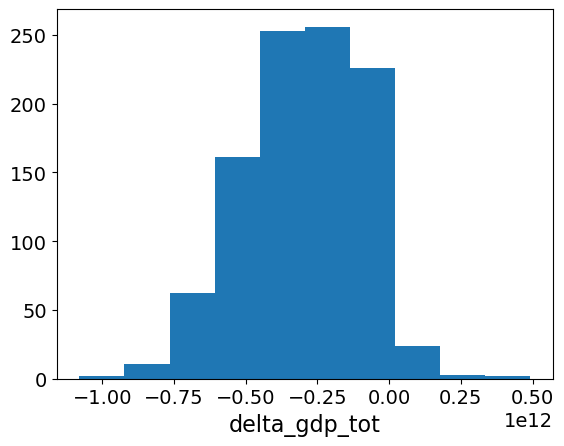

In [49]:
cnty_data_huc4_ds['delta_gdp_tot'].sum("year").plot.hist()

<Axes: >

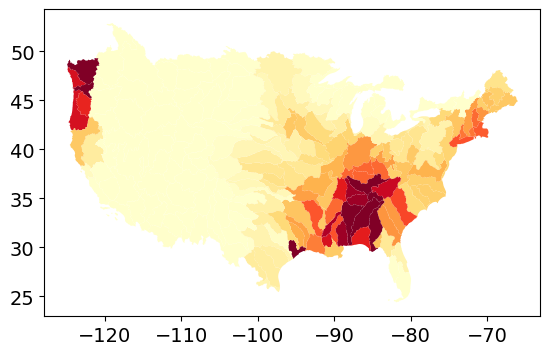

In [50]:
delta_gdp_df = gdf.merge(cnty_data_huc4_ds[['delta_gdppc','delta_gdp']].sum("year").mean('index').to_dataframe().reset_index(),on='huc4')
delta_gdp_df.plot(column='delta_gdppc',vmin=-3e3,vmax=0,cmap='YlOrRd_r')

In [44]:
fp = np.linspace(mod_mat['p_exc_rxmon'].min(),mod_mat['p_exc_rxmon'].max(),1000)
me0 = huc4_bs.loc['p_exc_rxmon'].values.reshape(-1,1)+2*np.outer(huc4_bs.loc['p_exc_rxmon_sq'],fp)
me1 = me0 + huc4_bs.loc['p_exc_rxmon_lag1'].values.reshape(-1,1)+2*np.outer(huc4_bs.loc['p_exc_rxmon_sq_lag1'],fp)
std_huc = mod_mat.groupby("huc4")['p_exc_rxmon'].std().mean()

In [45]:
cnty_coef = pd.read_csv(os.path.join(project_dir,'data','processed','damage_func_coefs',f'imerg_clsm-grace','county_se',f'lag1.csv')).set_index("Coefficient") 
mod_mat_cnty = pd.read_csv(os.path.join(project_dir,'data','processed','panels','imerg_clsm-grace_county_panel.csv'))
std_cnty = mod_mat_cnty.groupby("county")['p_exc_rxmon'].std().mean()

In [46]:
fp_cnty = np.linspace(mod_mat_cnty['p_exc_rxmon'].min(),
                      mod_mat_cnty['p_exc_rxmon'].max(),
                      1000)
me0_cnty =  cnty_coef.loc['p_exc_rxmon'].values.reshape(-1,1)+2*np.outer(cnty_coef.loc['p_exc_rxmon_sq'],fp_cnty)
me1_cnty =  me0_cnty+cnty_coef.loc['p_exc_rxmon_lag1'].values.reshape(-1,1)+2*np.outer(cnty_coef.loc['p_exc_rxmon_sq_lag1'],fp_cnty)

In [47]:
cnty_coef_ds = xr.Dataset.from_dataframe(cnty_coef.transpose())
cnty_panel_ds = xr.Dataset.from_dataframe(mod_mat_cnty.set_index(['county','year'])[['p_exc_rxmon']])
me_obs_cnty = cnty_coef_ds['p_exc_rxmon']+2*cnty_coef_ds['p_exc_rxmon_sq']*cnty_panel_ds['p_exc_rxmon']

In [51]:
cnty_gdp = pd.read_csv(os.path.join(project_dir,'data','raw','econ','us_county_gdp_01-23.csv'))
cnty_gdp = cnty_gdp[cnty_gdp['Description']=='Real GDP (thousands of chained 2017 dollars) ']
cnty_gdp_long = cnty_gdp.melt(id_vars=['GeoFIPS','GeoName'],value_vars=[str(y) for y in np.arange(2001,2024)],var_name='year',value_name='gdp')
cnty_gdp_long = cnty_gdp_long[cnty_gdp_long['GeoName'].str.contains(",")]
cnty_gdp_long['gdp'] = cnty_gdp_long['gdp'].replace({"(NA)":np.nan})
cnty_gdp_long['gdp'] = 1e3*cnty_gdp_long['gdp'].astype(float)
cnty_gdp_long['year'] = cnty_gdp_long['year'].astype(int)

cnty_pop = pd.read_csv(os.path.join(project_dir,'data','raw','econ','us_county_income_69-23.csv'))
cnty_pop = cnty_pop[cnty_pop['Description']=='Population (persons) 1/']
cnty_pop_long = cnty_pop.melt(id_vars=['GeoFIPS','GeoName'],value_vars=[str(y) for y in np.arange(2001,2024)],var_name='year',value_name='pop')
cnty_pop_long = cnty_pop_long[cnty_pop_long['GeoName'].str.contains(",")]
cnty_pop_long['pop'] = cnty_pop_long['pop'].replace({"(NA)":np.nan})
cnty_pop_long['pop'] = cnty_pop_long['pop'].astype(float)
cnty_pop_long['year'] = cnty_pop_long['year'].astype(int)

cnty_data = cnty_gdp_long.merge(cnty_pop_long[['GeoFIPS','year','pop']],on=['GeoFIPS','year'])
cnty_data['gdppc'] = cnty_data['gdp']/cnty_data['pop']
cnty_data = cnty_data.rename(columns={"GeoFIPS":"county"})
cnty_ds = xr.Dataset.from_dataframe(cnty_data.set_index(['county','year']))
cnty_ds['growth'] = np.log(cnty_ds['gdppc'])-np.log(cnty_ds['gdppc'].shift(year=1))

cnty_ds['delta_growth'] = me_obs_cnty.clip(max=0)*cnty_panel_ds['p_exc_rxmon']/100
cnty_ds['delta_gdppc'] = cnty_ds['gdppc'].shift(year=1)*cnty_ds['delta_growth']
cnty_ds['delta_gdp'] = cnty_ds['delta_gdppc']*cnty_ds['pop']
cnty_ds['delta_gdp_tot'] = cnty_ds['delta_gdp'].sum('county')

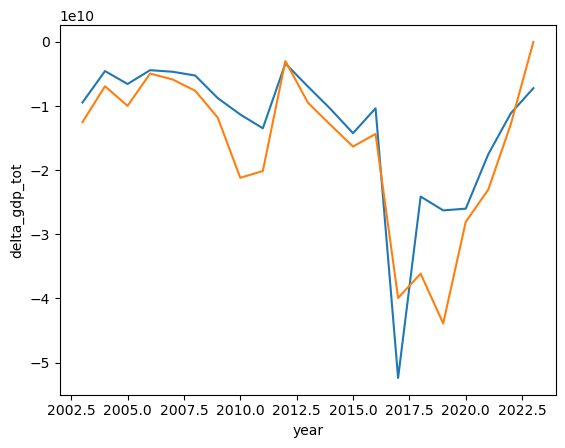

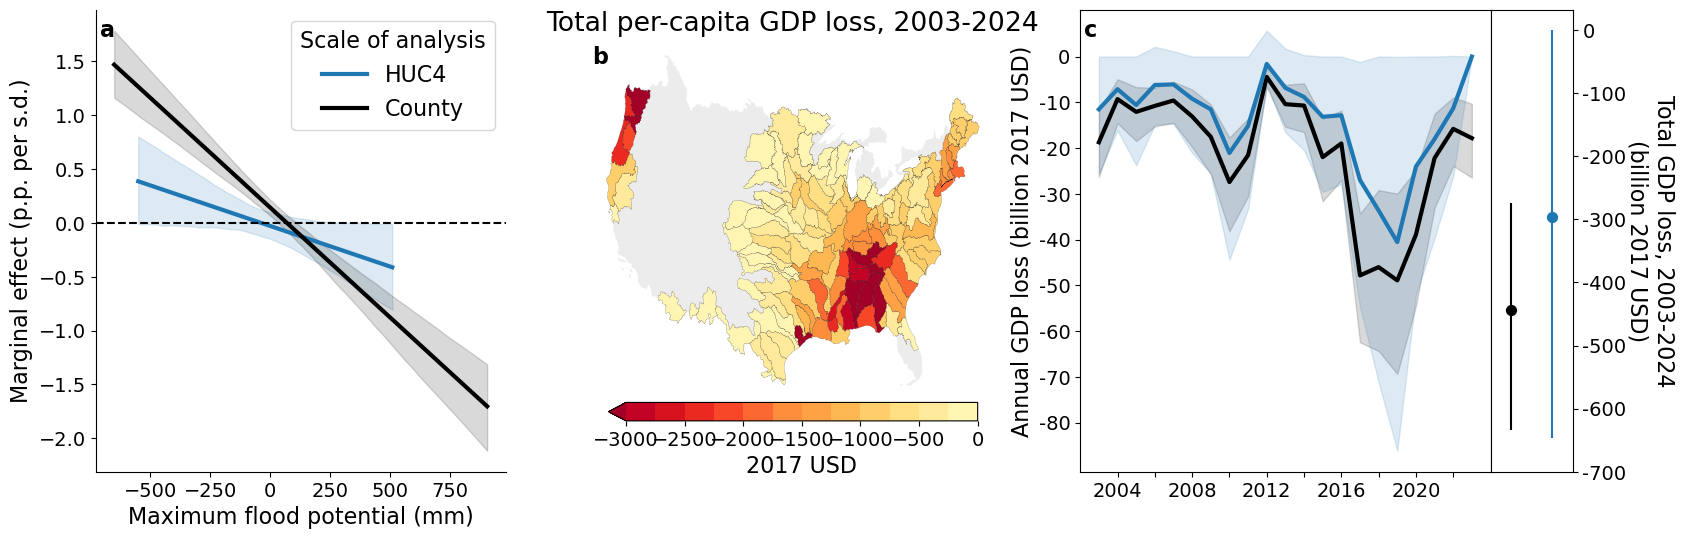

In [56]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib as mpl
import cartopy
import cartopy.crs as ccrs
import seaborn as sns

dmg_levels = np.arange(-3e3,1,250)
dmg_cols = sns.color_palette("YlOrRd_r",len(dmg_levels))
dmg_cmap = mpl.colors.ListedColormap(dmg_cols[1:])
dmg_cmap.set_under(dmg_cols[0])
dmg_cmap.set_over('tab:grey')
dmg_norm = plt.Normalize(vmin=-3e3,vmax=0)

fig = plt.figure(figsize=(18,6))
gs = gridspec.GridSpec(nrows=1,ncols=3,figure=fig)
ax = plt.subplot(gs[0])
ax.plot(fp,std_huc*me0.mean(axis=0),color='tab:blue',lw=3,label='HUC4')
ax.fill_between(fp,
                std_huc*np.quantile(me0,0.05,axis=0),
                std_huc*np.quantile(me0,0.95,axis=0),
                color='tab:blue',alpha=0.15)
ax.plot(fp_cnty,std_cnty*me0_cnty.mean(axis=0),color='black',lw=3,label='County')
ax.fill_between(fp_cnty,
                std_cnty*np.quantile(me0_cnty,0.025,axis=0),
                std_cnty*np.quantile(me0_cnty,0.975,axis=0),
                color='black',alpha=0.15)
ax.axhline(0,color='black',linestyle='--')
ax.legend(title='Scale of analysis')
ax.set_ylabel("Marginal effect (p.p. per s.d.)")
ax.set_xlabel("Maximum flood potential (mm)")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax2 = plt.subplot(gs[1],projection=ccrs.AlbersEqualArea(central_longitude=-96,central_latitude=37.5,standard_parallels=(29.5, 45.5)))
delta_gdp_df[delta_gdp_df['delta_gdppc']<0].plot(ax=ax2,transform=ccrs.PlateCarree(),column='delta_gdppc',cmap=dmg_cmap,norm=dmg_norm,edgecolor='black',lw=0.1)
delta_gdp_df[delta_gdp_df['delta_gdppc']>=0].plot(ax=ax2,transform=ccrs.PlateCarree(),color='grey',alpha=0.15)
ax2.title.set_text("Total per-capita GDP loss, 2003-2024")
dmg_cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=dmg_norm,cmap=dmg_cmap),ax=ax2,orientation='horizontal',extend='min',shrink=0.9,pad=0)
dmg_cbar.ax.set_xlabel('2017 USD')
ax2.set_frame_on(False)

ax3 = plt.subplot(gs[2])
years = np.arange(2003,2024)
ax3.plot(years,cnty_ds['delta_gdp_tot'].sel(year=years).mean("index"),color='black',lw=3)
ax3.fill_between(years,
                 cnty_ds['delta_gdp_tot'].sel(year=years).quantile(0.05,"index"),
                 cnty_ds['delta_gdp_tot'].sel(year=years).quantile(0.95,"index"),
                 color='black',alpha=0.15)
ax3.plot(years,cnty_data_huc4_ds['delta_gdp_tot'].sel(year=years).mean("index"),color='tab:blue',lw=3)
ax3.fill_between(years,
                 cnty_data_huc4_ds['delta_gdp_tot'].sel(year=years).quantile(0.05,"index"),
                 cnty_data_huc4_ds['delta_gdp_tot'].sel(year=years).quantile(0.95,"index"),
                 color='tab:blue',alpha=0.15)
ax3.set_yticks(np.arange(-8e10,1,1e10))
ax3.set_yticklabels(np.arange(-80,1,10))
ax3.set_ylabel("Annual GDP loss (billion 2017 USD)")
ax3.set_xticks(years[1::2])
for l in ax3.get_xticklabels()[1::2]:
    l.set_visible(False)
ax3_ins = ax3.inset_axes([1,0,0.2,1])
ax3_ins.scatter([-0.5],cnty_ds['delta_gdp_tot'].sum("year").mean("index"),color='black',s=50)
ax3_ins.vlines([-0.5],
               cnty_ds['delta_gdp_tot'].sum("year").quantile(0.05,"index"),
               cnty_ds['delta_gdp_tot'].sum("year").quantile(0.95,"index"),
               color='black')
ax3_ins.scatter([0.5],cnty_data_huc4_ds['delta_gdp_tot'].sum("year").mean("index"),color='tab:blue',s=50)
ax3_ins.vlines([0.5],
               cnty_data_huc4_ds['delta_gdp_tot'].sum("year").quantile(0.05,"index"),
               cnty_data_huc4_ds['delta_gdp_tot'].sum("year").quantile(0.95,"index"),
               color='tab:blue')
ax3_ins.set_xticks([])
ax3_ins.yaxis.tick_right()
ax3_ins.yaxis.set_label_position("right")
ax3_ins.set_yticks(np.arange(-7e11,1,1e11))
ax3_ins.set_yticklabels(np.arange(-700,1,100))
ax3_ins.set_ylabel("Total GDP loss, 2003-2024\n(billion 2017 USD)",rotation=-90,labelpad=35)
ax3_ins.set_xlim(-1,1)

labels=['a','b','c']
for i,ax in enumerate([ax,ax2,ax3]):
    ax.text(0.01,0.98,labels[i],ha='left',va='top',fontsize=16,fontweight='bold',transform=ax.transAxes)
plt.savefig(os.path.join(project_dir,'figures','supp_mat','huc4_damage.png'),bbox_inches='tight',dpi=350)
plt.savefig(os.path.join(project_dir,'figures','supp_mat','huc4_damage.pdf'),bbox_inches='tight',dpi=350)
plt.show()